In [59]:
%cd ..
!pip install .
%cd ./examples

/Users/aymeric.quesne/fsl-lib/tensorflow-fewshot
Processing /Users/aymeric.quesne/fsl-lib/tensorflow-fewshot
  Created wheel for tensorflow-fewshot: filename=tensorflow_fewshot-0.0.2-py3-none-any.whl size=20966 sha256=dba0138bfaa2faddb98bfcb7acf13c39e5b7b3d4dcede45e6063d519920ceb5d
  Stored in directory: /Users/aymeric.quesne/Library/Caches/pip/wheels/d2/bb/6f/5d51cad355b9b9dfe040938fbcdaa8e10b67ee9aa53a21fe56
Successfully built tensorflow-fewshot
  Attempting uninstall: tensorflow-fewshot
    Found existing installation: tensorflow-fewshot 0.0.2
    Uninstalling tensorflow-fewshot-0.0.2:
      Successfully uninstalled tensorflow-fewshot-0.0.2
/Users/aymeric.quesne/fsl-lib/tensorflow-fewshot/examples


In [60]:
import importlib
importlib.reload(maml)

<module 'tensorflow_fewshot.models.maml' from '/Users/aymeric.quesne/anaconda3/envs/tf-fs-examples/lib/python3.7/site-packages/tensorflow_fewshot/models/maml.py'>

### Example of using the MAML implementation to learn the 5-way 5-shot task on the Omniglot dataset

In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath(os.path.relpath('../tensorflow_fewshot/')))

In [2]:
import tensorflow_fewshot.models.maml as maml
import tensorflow_fewshot.models.utils as models_utils
from tensorflow_fewshot.datasets import MetaDatasetFromArray

In [3]:
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

from IPython.display import display, clear_output

# Dataset

In [191]:
def sine(n_task=10):
    for _ in range(n_task):
        x = np.random.uniform(-5, 5, size=(20,1,1,1))
        a = np.random.uniform(0.1, 5)
        p = np.random.uniform(0, np.pi)
        y = a*np.sin(x + p)
        support = x[1::2], y[1::2]
        query = x[::2], y[::2]
        yield support, query

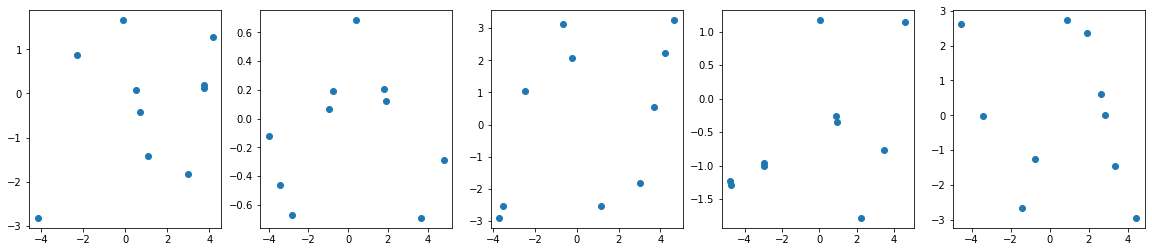

In [192]:
plt.figure(figsize=(20,4))
ds = sine()
for i in range(5):
    support, _ = ds.__next__()
    plt.subplot(1,5,i+1)
    plt.scatter(support[0], support[1])

# Meta-train

In [193]:
encoder = tf.keras.models.Sequential([
  tf.keras.layers.Input((1,)),
  tf.keras.layers.Dense(40, activation='relu'),
  tf.keras.layers.Dense(40, activation='relu'),
  tf.keras.layers.Dense(1),
])
encoder.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 40)                80        
_________________________________________________________________
dense_18 (Dense)             (None, 40)                1640      
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 41        
Total params: 1,761
Trainable params: 1,761
Non-trainable params: 0
_________________________________________________________________


In [194]:
support, _ = sine().__next__()
encoder(support[0])

<tf.Tensor: shape=(10, 1, 1, 1), dtype=float32, numpy=
array([[[[-0.50410676]]],


       [[[-0.98150516]]],


       [[[-0.1060005 ]]],


       [[[-0.11258779]]],


       [[[-0.38707143]]],


       [[[-0.47002977]]],


       [[[-0.28291994]]],


       [[[-0.230444  ]]],


       [[[-0.05679512]]],


       [[[-1.6572018 ]]]], dtype=float32)>

In [195]:
support[0].shape

(10, 1, 1, 1)

In [196]:
model = maml.MAML(encoder, tf.keras.losses.mse)

In [200]:
def evaluate(model, ds, n_task=10, verbose=False):
    mse = []
    
    i = 1
    for support_set, query_set in sine(n_task=n_task):
        if verbose:
            clear_output(wait=True)
            display('Eval task ' + str(i) + ' of ' + str(n_task))

        support_x, support_y = support_set
        query_x, query_y = query_set

        finetuned_model = model.fit(support_x, support_y, alpha=0.001, n_step=5)

        preds = finetuned_model(query_x)
        mse.append(np.sqrt(np.sum(np.square(preds - query_y))))
        i += 1
    return mse

In [201]:
from shutil import copyfile

In [204]:
losses = []
val_losses = []
def episode_callback(**kwargs):
    if kwargs['episode']%10 == 0:
        outer_grads = kwargs['episode_gradients'][-2] # Head kernel
        grad_norm = np.sqrt(np.sum(np.square(outer_grads)))
        epi_loss = np.mean(kwargs['episode_loss'].numpy())
        print(
            "Episode", kwargs['episode'],
            "outer loss:", epi_loss,
            "outer gradient norm:", grad_norm)
        losses.append(epi_loss)
    if kwargs['episode']%100 == 0:
        val_losses.append(np.mean(evaluate(model, sine)))
        print("At episode", kwargs['episode'], "Validation MSE:", np.mean(evaluate(model, sine)))

def train():
    model.meta_train(
        sine,
        n_episode=70000,
        alpha=0.001,
        n_step=5,
        optimizer=tf.keras.optimizers.Adam(1e-3, clipvalue=10.0),
        episode_end_callback=episode_callback
    )

In [205]:
train()

Episode 0 outer loss: 29.689045 outer gradient norm: 79.64129
At episode, 0 Validation MSE: 4.670379
Episode 10 outer loss: 78.772736 outer gradient norm: 255.69363
Episode 20 outer loss: 44.093597 outer gradient norm: 136.82285
Episode 30 outer loss: 19.990177 outer gradient norm: 73.88615
Episode 40 outer loss: 19.080275 outer gradient norm: 16.967655
Episode 50 outer loss: 29.999537 outer gradient norm: 82.806656
Episode 60 outer loss: 45.514233 outer gradient norm: 126.49064
Episode 70 outer loss: 44.767403 outer gradient norm: 135.81447
Episode 80 outer loss: 21.617836 outer gradient norm: 59.871704
Episode 90 outer loss: 31.168253 outer gradient norm: 47.908802
Episode 100 outer loss: 39.147026 outer gradient norm: 91.46491
At episode, 100 Validation MSE: 5.56226
Episode 110 outer loss: 33.55616 outer gradient norm: 26.564383
Episode 120 outer loss: 33.670204 outer gradient norm: 146.5836
Episode 130 outer loss: 28.02796 outer gradient norm: 51.259106
Episode 140 outer loss: 40.7

Episode 1200 outer loss: 9.151019 outer gradient norm: 74.767426
At episode, 1200 Validation MSE: 2.4683995
Episode 1210 outer loss: 4.671283 outer gradient norm: 40.881256
Episode 1220 outer loss: 6.285952 outer gradient norm: 77.80012
Episode 1230 outer loss: 4.09848 outer gradient norm: 11.18395
Episode 1240 outer loss: 6.52143 outer gradient norm: 103.63036
Episode 1250 outer loss: 8.836767 outer gradient norm: 72.632416
Episode 1260 outer loss: 11.068539 outer gradient norm: 91.084785
Episode 1270 outer loss: 12.77377 outer gradient norm: 37.548107
Episode 1280 outer loss: 12.001738 outer gradient norm: 63.23087
Episode 1290 outer loss: 4.289481 outer gradient norm: 64.06902
Episode 1300 outer loss: 8.374674 outer gradient norm: 47.833145
At episode, 1300 Validation MSE: 3.0681663
Episode 1310 outer loss: 5.271865 outer gradient norm: 41.956932
Episode 1320 outer loss: 4.210518 outer gradient norm: 39.623425
Episode 1330 outer loss: 6.6843276 outer gradient norm: 34.720406
Episode

Episode 2390 outer loss: 7.698329 outer gradient norm: 57.004253
Episode 2400 outer loss: 3.0386136 outer gradient norm: 28.763048
At episode, 2400 Validation MSE: 1.4329827
Episode 2410 outer loss: 2.4509346 outer gradient norm: 50.031803
Episode 2420 outer loss: 4.3250175 outer gradient norm: 53.093613
Episode 2430 outer loss: 6.9326487 outer gradient norm: 54.243156
Episode 2440 outer loss: 7.5977798 outer gradient norm: 82.23481
Episode 2450 outer loss: 7.4154015 outer gradient norm: 76.07654
Episode 2460 outer loss: 6.8170075 outer gradient norm: 46.33508
Episode 2470 outer loss: 4.1915364 outer gradient norm: 49.33175
Episode 2480 outer loss: 3.383662 outer gradient norm: 19.473743
Episode 2490 outer loss: 1.8565047 outer gradient norm: 23.786032
Episode 2500 outer loss: 5.1529703 outer gradient norm: 39.55078
At episode, 2500 Validation MSE: 1.6112802
Episode 2510 outer loss: 3.9112315 outer gradient norm: 46.83927
Episode 2520 outer loss: 7.3210588 outer gradient norm: 31.82514

KeyboardInterrupt: 

In [ ]:
# encoder.save('my_awesome_model.h5')

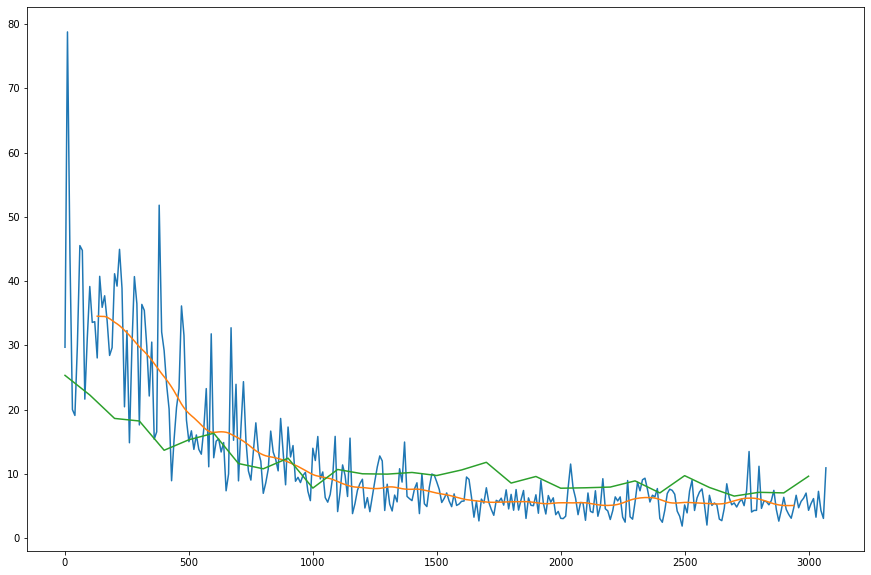

In [229]:
plt.figure(figsize=(15, 10))
xx = np.arange(0, 10*len(losses), 10)
plt.plot(xx, losses)
smoothed = np.convolve(losses, np.exp(-0.01*np.arange(7))/np.sum(np.exp(-0.01*np.arange(7))), 'valid')
smootheded = np.convolve(smoothed, np.exp(-0.01*np.arange(7))/np.sum(np.exp(-0.01*np.arange(7))), 'valid')
plt.plot(xx[13:-13], np.convolve(smootheded, np.exp(-0.01*np.arange(15))/np.sum(np.exp(-0.01*np.arange(15))), 'valid'))
plt.plot(xx[::10], 4*np.array(val_losses))

# Evaluation on one task

In [16]:
from tensorflow_fewshot.models.gradient_utils import take_one_gradient_step, take_n_gradient_step

In [ ]:
!cp /content/drive/My\ Drive/models/maml_miniimagenet_ep_19000.h5 ./

In [ ]:
test_model = tf.keras.models.load_model('maml_miniimagenet_ep_19000.h5')

In [ ]:
# Change MAML internal model for demonstration's sake
model.model = test_model

In [212]:
x = np.random.uniform(-5, 5, size=(20,1,1,1))
a = np.random.uniform(0.1, 5)
p = np.random.uniform(0, np.pi)
y = a*np.sin((x + p))
support_x, support_y = x[1::2], y[1::2]
query_x, query_y = x[::2], y[::2]
nice_x = np.linspace(-5, 5, 50)
nice_y = a*np.sin((nice_x + p))

In [213]:
finetuned_model = model.fit(support_x, support_y, alpha=0.001, n_step=5)
query_preds = finetuned_model(nice_x)

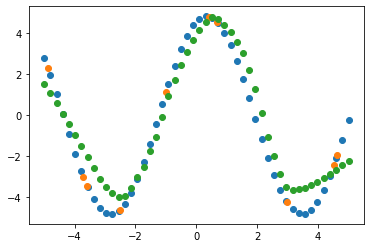

In [214]:
plt.scatter(nice_x, nice_y)
plt.scatter(support_x, support_y)
plt.scatter(nice_x, query_preds)

# Accuracy evaluation

In [ ]:
test_set = np.load('/content/miniImageNet/mini-imagenet-cache-test.pkl', allow_pickle=True)

In [ ]:
test_X = test_set['image_data']/255
test_Y = np.zeros((test_X.shape[0],), dtype=np.int32)
for i_lbl, class_label in enumerate(test_set['class_dict']):
    for i_sample in test_set['class_dict'][class_label]:
        test_Y[i_sample] = i_lbl


In [ ]:
test_ds = MetaDatasetFromArray(test_X, test_Y)

In [ ]:
n_task = 1000
acc, var = evaluate(model, test_ds, n_task)

In [ ]:
mean_acc = np.mean(acc)
stds = np.std(acc)
ci95 = 1.96*stds/np.sqrt(n_task)
print("Accuracy is", round(mean_acc*100, 1), "% +/-", round(ci95*100, 2), "%")